In [1]:
import pandas as pd
import numpy as np
import json
import pickle
from collections import Counter, defaultdict
from itertools import product
from sklearn.metrics import confusion_matrix
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
from bidict import bidict
from statistics import mean
from multiprocessing import Process
import sys
import os
import re
import kenlm
import matplotlib.pyplot as plt
import seaborn as sns
from ggplot import aes, xlab, ylab, geom_point, geom_histogram, geom_line, facet_grid, facet_wrap, ggplot

/u/solimanz/development/career_prediction_gpu/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/u/solimanz/development/career_prediction_gpu/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/u/solimanz/development/career_prediction_gpu/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
%matplotlib inline
plt.style.use(['dark_background', 'ggplot'])
sns.set(color_codes=True)
sns.set_palette(sns.color_palette('dark'))

In [3]:
def groupby_length(seq_lengths):
    d = dict()    
    for i in range(2, seq_lengths.max()+1):
        d[i] = np.where(seq_lengths == i)[0]
    return d


        
def accuracy_by_length(preds, targets, groups, k=1):
    """
    preds: predictions of the model (n_examples, max_length, n_labels)
    targets: prediction targets with shape (n_examples, max_lenth, n_labels)
    groups: dictionary grouping the indices of the input sequences by length"""
    
    length_acc = dict()    
    for length, indices in groups.items():
        if len(indices) > 0:
            if len(preds.shape) == 3:
                p = preds[indices, length-1, :]
                t = np.argmax(targets[indices, length-1, :], axis=1)
                length_acc[length] = top_k_acc(p, t, k)
            else:
                p = preds[indices]
                t = targets[indices]
                length_acc[length] = top_k_acc(p, t, k)
        
    return length_acc

def to_python_lists(np_arr, lengths):
    return [row[:length] for row, length in zip(np_arr, lengths)]

def count_transitions(sequences):
    trans = [list(zip(seq[:-1], seq[1:])) for seq in sequences]
    trans = sum(trans, [])
    
    return Counter(trans)

def normalize_counter(counts):
    total = sum(counts.values(), 0)
    for key in counts:
        counts[key] /= total
    
    return counts

def get_ngrams(n, tokens):    
    return [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]

def get_index(target, top_preds):    
    indices = np.where(top_preds == target)[0]
    if len(indices) == 0:
        return -1
    
    return indices[0]

# Load Datasets

In [4]:
path550 = "/data/rali7/Tmp/solimanz/data/datasets/top550/"
path7k = "/data/rali7/Tmp/solimanz/data/datasets/reduced7000/"

# Load data dicts
with open(os.path.join(path550, "jobid", "data.json"), "r") as f:
    data550 = json.load(f)
with open(os.path.join(path7k, "jobid", "data.json"), "r") as f:
    data7k = json.load(f)

# Fetch Predictive Model Results

In [5]:
def next_batch(path):
    batch = 0
    name = os.path.basename(path)
    while os.path.exists(os.path.join(path, f"{name}_batch_{batch}.npy")):
        with open(os.path.join(path, f"{name}_batch_{batch}.npy"), "rb") as f:
            matrix = np.load(f)
        batch += 1
        yield matrix
        
def get_neural_predictions(model, dataset):
    result_path = "/data/rali7/Tmp/solimanz/data/model_predictions"
    gen = next_batch(os.path.join(result_path, dataset, model, "predictions"))
    predictions = []
    
    for preds in gen:
        p = preds.reshape(preds.shape[1], preds.shape[2])
        predictions.append((-p).argsort(axis=1)[:, :10].shape)
    
    predictions = np.concatenate(predictions)
    
    return predictions

# Predict Most Probable Baseline

# Predict Last Baseline

# KenLM Baseline

## Prepare Data For KenLM

In [6]:
def prepare_KenLM(train_data, dataset):
    train_txt = "\n".join([" ".join([str(i) for i in dat[1]]) for dat in train_data])
    
    with open(f"/data/rali7/Tmp/solimanz/data/datasets/ngrams/train_{dataset}.txt", "w") as f:
        f.write(train_txt)

In [7]:
prepare_KenLM(data550['train_data'], '550')
prepare_KenLM(data7k['train_data'], '7k')

## Make Predictions

In [8]:
n_7k = len(data7k['title_to_id'])
n_550 = len(data550['title_to_id'])

In [9]:
def kenlm_predict(test, n_labels, n=2, model_binary='bigram550'):    
    model = kenlm.Model(f"../../kenlm/build/{model_binary}.binary")
    model_preds = np.zeros((len(test), n_labels))
    
    for j, seq in enumerate(test):
        test_seq = seq[-(n-1):]
        for i in range(n_labels):
            model_preds[j][i] = model.score(" ".join(test_seq + [str(i)]))      

    return (-model_preds).argsort(axis=1)[:, :10]

In [10]:
models_550 = [(2, 'bigram550'),
              (3, 'trigram550'),
              (4, '4gram550'),
              (5, '5gram550')]

models_7k = [(2, 'bigram7k'),
             (3, 'trigram7k'),
             (4, '4gram7k'),
             (5, '5gram7k')]

In [11]:
def worker(test_data, n_labels, n, model):
    preds = kenlm_predict(test_data, n_labels, n, model)
    #filename = model.split('.')[0]
    np.save(f'/data/rali7/Tmp/solimanz/data/ngram_preds/{model}.npy', preds)

In [12]:
def run_KenLM_multi(models, data, n_labels):
    test_data = [[str(i) for i in dat[1][:-1]] for dat in data["test_data"]]
    jobs = []
    for n, model in models:
        p = Process(target=worker, args=(test_data, n_labels, n, model))
        jobs.append(p)
        p.start()

In [13]:
def run_KenLM(models, data, n_labels, result_dict=None):
    if result_dict is None:
        result_dict = dict()

    test_data = [[str(i) for i in dat[1][:-1]] for dat in data["test_data"]]
    for n, model in models:
        p = Process
        key = re.split(r"550|7k", model)[0]
        result_dict[key] = kenlm_predict(test_data, n_labels, n, model)
    
    return result_dict

In [14]:
run_KenLM_multi(models_550, data550, n_550)

In [15]:
run_KenLM_multi(models_7k, data7k, n_7k)

In [ ]:
with open('/data/rali7/Tmp/solimanz/data/pickles/res550.pkl', 'wb') as f:
    pickle.dump(file=f, obj=res550)
with open('/data/rali7/Tmp/solimanz/data/pickles/res7k.pkl', 'wb') as f:
    pickle.dump(file=f, obj=res7k)

In [26]:
models = [t[1].split('.')[0] for t in models_550] + [t[1].split('.')[0] for t in models_7k]

In [35]:
def fetch_ngram_results(models, res_dict=None):
    if res_dict is None:
        res_dict = dict()
    ngram_preds_path = "/data/rali7/Tmp/solimanz/data/ngram_preds/"
    
    for model in models:
        res_dict[model[1]] = np.load(os.path.join(ngram_preds_path, model[1] + '.npy'))

In [36]:
res550 = dict()
res7k = dict()

In [37]:
fetch_ngram_results(models_550, res550)
fetch_ngram_results(models_7k, res7k)

# Analysis

## Distribution of Job Title Targets

## Accuracy Comparison

In [38]:
targets_550 = [d[1][-1] for d in data550['test_data']]
targets_7k = [d[1][-1] for d in data7k['test_data']]

In [61]:
def top_k_acc(preds, targets, k=1):
    """
    preds has shape (n_examples, n_labels)
    targets has shape (n_examples, 1)
    """

    #sorted_args = (-preds).argsort(axis=1)[:,:k]
    sorted_args = preds[:,:k]
    tt = np.tile(targets, (k,1)).T
    acc = np.mean(np.sum(sorted_args == tt, axis=1))
    return acc

def get_acc_df(preds, targets, dataset):
    
    ks = list(range(1,11))
    df_dict = {
    'dataset': [],
    'top_k': [],
    'model': [],
    'accuracy': []
    }

    for name, ps in preds.items():
        for k in ks:
            df_dict['dataset'].append(dataset)
            df_dict["model"].append(name)
            df_dict["top_k"].append(k)
            df_dict["accuracy"].append(round(top_k_acc(ps, targets, k), 5)*100)
            
    return pd.DataFrame(df_dict)

### N-gram Models

In [73]:
accs_550 = get_acc_df(res550, targets_550, '550_titles')
accs_7k = get_acc_df(res7k, targets_7k, '7k_titles')

In [74]:
accs = pd.concat([accs_550, accs_7k])

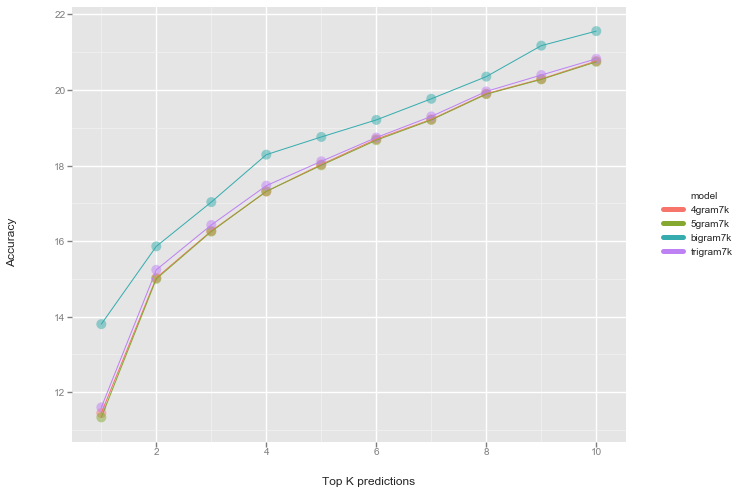

<ggplot: (8732137141701)>

In [75]:
ggplot(aes(x='top_k', y='accuracy', color='model'), data=accs_7k) \
+ geom_point(size=100, alpha=0.5) \
+ geom_line() \
+ xlab("Top K predictions") \
+ ylab("Accuracy") \

### Neuronal Models